In [165]:
import pandas as pd
import json
from datetime import datetime, timedelta
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as py
from IPython.display import Image
# !pip install dask
# import dask.dataframe as dd


In [166]:
file_json = pd.read_json('output_file.json')

![strategy](images/strategy.png)

## Reference
https://www.kaggle.com/code/deffro/eda-is-fun/notebook#The-Healers
添加在大数据情况下的置信区间
Baseline XGBoost and features importance

https://www.gcores.com/articles/168052

## CONSTANT

In [167]:
GAME_ID = "val:6ac110c8-4048-421e-8b2b-86d3ac6c72ed"
SMOOTHING = 3
CHART_COLOR = "Viridis"
TOTAL_ROUND_NUM = file_json['gamePhase'].dropna().iloc[-1]['roundNumber'] + 1 #用其他方式统计
FINAL_STATE = file_json['gamePhase'].dropna().iloc[-1]['phase']
df_game_decided_clean = pd.DataFrame(file_json['gameDecided']).dropna()
RESULT = df_game_decided_clean['gameDecided'].iloc[0]['state']
WINNINGTEAM = df_game_decided_clean['gameDecided'].iloc[0]['winningTeam']['value']
print(RESULT, 'Team', WINNINGTEAM)
print(FINAL_STATE, TOTAL_ROUND_NUM)


WINNER_DECIDED Team 19
GAME_ENDED 17


In [168]:
# utility function

def print_json_keys(d, parent_key=""):

    for k, v in d.items():
        current_key = f"{parent_key}.{k}" if parent_key else k
        print(current_key)
        
        # If value is a dictionary, recursively go deeper
        if isinstance(v, dict):
            print_json_keys(v, current_key)
        # If value is a list, check if items are dictionaries
        elif isinstance(v, list):
            for item in v:
                if isinstance(item, dict):
                    print_json_keys(item, current_key)

def print_keys(df, column_name = None):
    # Use set comprehension to gather keys from dictionaries in the specified column
    if column_name:
        all_keys = {key for event in df[column_name] if isinstance(event, dict) for key in event.keys()}
    else:
        # 没有column的情况应该一定不会出现
        all_keys = {key for event in df if isinstance(event, dict) for key in event.keys()}
    print(all_keys)
    
def print_all_keys(df, column_name=None):
    def extract_keys(d):
        keys = set()
        for k, v in d.items():
            keys.add(k)
            if isinstance(v, dict):  # If value is another dictionary, recurse
                keys.update(extract_keys(v))
        return keys

    all_keys = set()

    # Handle the case where a column name is provided
    if column_name:
        for event in df[column_name]:
            if isinstance(event, dict):
                all_keys.update(extract_keys(event))
    else:
        for event in df:
            if isinstance(event, dict):
                all_keys.update(extract_keys(event))
    print(all_keys)
    return all_keys 
def count_unique_values(df, column_name, key):
    value_counts = {}
    
    # Iterate through the column of dictionaries
    for event in df[column_name]:
        if isinstance(event, dict) and key in event:
            value = event[key]
            # Count occurrences of each unique value
            if value in value_counts:
                value_counts[value] += 1
            else:
                value_counts[value] = 1
    print(value_counts)

def format_float(value, decimal_places=2):
    return round(value, decimal_places)

In [169]:
# Print all keys in the JSON structure
all_main_keys = print_json_keys(file_json)

platformGameId
metadata
snapshot
configuration
gamePhase
playerSpawn
roundStarted
spikeStatus
observerTarget
inventoryTransaction
abilityUsed
damageEvent
playerDied
roundDecided
roundCeremony
roundEnded
spikePlantStarted
spikePlantCompleted
spikeDefuseStarted
spikeDefuseCheckpointReached
spikeDefuseStopped
playerDowned
timeout
playerRecovered
spikePlantStopped
gameDecided



snapshot (每一秒一次记录)
configuration （每次对局开始一次记录， 在gamePhase.phase 为  GAME_STARTED 之前）
    {'attackingTeam', 'completedRounds', 'currentRound', 'players', 'guid', 'roundsToWin', 'value', 'defendingTeam', 'fallback', 'displayName', 'id', 'spikeMode', 'selectedMap', 'teams'}
    {'teams', 'players', 'spikeMode', 'selectedMap'}
gameDecided (有很多有用的信息——在最后汇总用)
    {'winningTeam', 'attackingTeam', 'completedRounds', 'currentRound', 'state', 'spikeMode', 'roundsToWin', 'defendingTeam', 'value'}



inventoryTransaction
abilityUsed
damageEvent


playerSpawn (对局开始时候的重生，在gamePhase.phase 为  GAME_STARTED -> BETWEEN_ROUND之后) 这里17局，共有170行数据
    {'player': {'value': 4}}
playerDied
    {'deceasedId', 'weapon', 'killerId', 'hazard', 'assistants'}
    {'deceasedId': {'value': 1}, 'weapon': {'fallback': {'displayName': '', 'inventorySlot': {'slot': 'SECONDARY'}, 'guid': '1BAA85B4-4C70-1284-64BB-6481DFC3BB4E'}, 'type': 'UNKNOWN'}, 'assistants': [], 'killerId': {'value': 9}}
playerRecovery (重生/恢复)
    {'recoveredById': {'value': 3}, 'recoveredId': {'value': 5}}
playerDowned
    {'downedById', 'weapon', 'downedId'}
    {'downedId': {'value': 5}, 'weapon': {'type': 'UNKNOWN', 'fallback': {'displayName': '', 'inventorySlot': {'slot': 'PRIMARY'}, 'guid': '462080D1-4035-2937-7C09-27AA2A5C27A7'}}, 'downedById': {'value': 9}}

roundStarted
    {'roundNumber': 1, 'spikeMode': {'currentRound': 1, 'attackingTeam': {'value': 18}, 'completedRounds': [], 'roundsToWin': 13, 'defendingTeam': {'value': 19}}}
roundDecided: 
    {'result': {'roundNumber': 1, 'spikeModeResult': {'attackingTeam': {'value': 18}, 'cause': 'ELIMINATION', 'defendingTeam': {'value': 19}}, 'winningTeam': {'value': 19}}}
roundCeremony
    {'fallback': {'guid': '00000000000000000000000000000000', 'displayName': 'DefaultCeremony_C'}, 'type': 'DEFAULT'}
    type: {'DEFAULT': 13, 'CLOSER': 3, 'CLUTCH': 1}

spikeStatus
    {'carrier': {'value': 10}, 'status': 'IN_HANDS'}
spikePlantStarted
    {'playerId': {'value': 6}}
spikePlantCompleted (显示地图中的炸弹安放位置，显示常用的进攻点位)
    {'plantLocation': {'y': -8185.40332, 'x': -3440.69702, 'z': -103.727417}, 'playerId': {'value': 6}}
spikeDefuseStarted
    {'playerId': {'value': 3}}
spikeDefuseCheckpointReached
    {'progress': '3.470s', 'playerId': {'value': 3}}
spikeDefuseStopped
    {'playerId': {'value': 3}}
spikePlantStopped
    {'playerId': {'value': 3}}

timeout 
    (Non-sense)
observerTarget
    (Non-sense)
    




In [170]:
col_str = 'inventoryTransaction'
df_test_cleaned = pd.DataFrame(file_json[col_str].dropna())
print_all_keys(df_test_cleaned, col_str)
print_keys(df_test_cleaned, col_str)
# df_test_cleaned.iloc[-1, :]


{'player', 'armor', 'value', 'inventorySlot', 'displayName', 'type', 'objective', 'guid', 'fallback', 'ability', 'weapon', 'transactionType', 'slot'}
{'player', 'armor', 'ability', 'weapon', 'transactionType', 'objective'}


In [235]:
GUID_DISPLAYNAME_DICT = {'29A0CFAB-485B-F5D5-779A-B59F85E204A8': 'Classic', '2F59173C-4BED-B6C3-2191-DEA9B58BE9C7': 'Melee', '1BAA85B4-4C70-1284-64BB-6481DFC3BB4E': 'Ghost', '0AFB2636-4093-C63B-4EF1-1E97966E2A3E': 'SPIKE', 'AE3DE142-4D85-2547-DD26-4E90BED35CF7': 'Bulldog', '462080D1-4035-2937-7C09-27AA2A5C27A7': 'Spectre', '9C82E19D-4575-0200-1A81-3EACF00CF872': 'Vandal', 'EE8E8D15-496B-07AC-E5F6-8FAE5D4C7B1A': 'Phantom', 'E336C6B8-418D-9340-D77F-7A9E4CFE0702': 'Sheriff', '42DA8CCC-40D5-AFFC-BEEC-15AA47B42EDA': 'Shorty', 'A03B24D3-4319-996D-0F8C-94BBFBA1DFC7': 'Operator', '4ADE7FAA-4CF1-8376-95EF-39884480959B': 'Guardian', 'EC845BF4-4F79-DDDA-A3DA-0DB3774B2794': 'Judge', 'F7E1B454-4AD4-1063-EC0A-159E56B58941': 'Stinger', 'C4883E50-4494-202C-3EC3-6B8A9284F00B': 'Marshal', '44D4E95C-4157-0037-81B2-17841BF2E8E3': 'Frenzy', '910BE174-449B-C412-AB22-D0873436B21B': 'Bucky'}
GUID_PRICE_DICT = {
    '42DA8CCC-40D5-AFFC-BEEC-15AA47B42EDA': 200,
    '29A0CFAB-485B-F5D5-779A-B59F85E204A8': 0,
    '44D4E95C-4157-0037-81B2-17841BF2E8E3': 400,
    '1BAA85B4-4C70-1284-64BB-6481DFC3BB4E': 500,
    'E336C6B8-418D-9340-D77F-7A9E4CFE0702': 800,
    'F7E1B454-4AD4-1063-EC0A-159E56B58941': 1000,
    '462080D1-4035-2937-7C09-27AA2A5C27A7': 1600,
    'AE3DE142-4D85-2547-DD26-4E90BED35CF7': 2100,
    '4ADE7FAA-4CF1-8376-95EF-39884480959B': 2700,
    'EE8E8D15-496B-07AC-E5F6-8FAE5D4C7B1A': 2900,
    '9C82E19D-4575-0200-1A81-3EACF00CF872': 2900,
    '910BE174-449B-C412-AB22-D0873436B21B': 900,
    'EC845BF4-4F79-DDDA-A3DA-0DB3774B2794': 1500,
    'C4883E50-4494-202C-3EC3-6B8A9284F00B': 1100,
    'A03B24D3-4319-996D-0F8C-94BBFBA1DFC7': 4500,
    'Odin': 3200,
    'Ares': 1700,
    'Arm': 1000,
}

In [172]:
# Offered by the discord
AGENT_CODES = { 
    "Jett": "add6443a-41bd-e414-f6ad-e58d267f4e95",
    "Reyna": "a3bfb853-43b2-7238-a4f1-ad90e9e46bcc",
    "Raze": "f94c3b30-42be-e959-889c-5aa313dba261",
    "Yoru": "7f94d92c-4234-0a36-9646-3a87eb8b5c89",
    "Phoenix": "eb93336a-449b-9c1b-0a54-a891f7921d69",
    "Neon": "bb2a4828-46eb-8cd1-e765-15848195d751",
    "Breach": "5f8d3a7f-467b-97f3-062c-13acf203c006",
    "Skye": "6f2a04ca-43e0-be17-7f36-b3908627744d",
    "Sova": "320b2a48-4d9b-a075-30f1-1f93a9b638fa",
    "Kayo": "601dbbe7-43ce-be57-2a40-4abd24953621",
    "Killjoy": "1e58de9c-4950-5125-93e9-a0aee9f98746",
    "Cypher": "117ed9e3-49f3-6512-3ccf-0cada7e3823b",
    "Sage": "569fdd95-4d10-43ab-ca70-79becc718b46",
    "Chamber": "22697a3d-45bf-8dd7-4fec-84a9e28c69d7",
    "Omen": "8e253930-4c05-31dd-1b6c-968525494517",
    "Brimstone": "9f0d8ba9-4140-b941-57d3-a7ad57c6b417",
    "Astra": "41fb69c1-4189-7b37-f117-bcaf1e96f1bf",
    "Viper": "707eab51-4836-f488-046a-cda6bf494859",
    "Fade": "dade69b4-4f5a-8528-247b-219e5a1facd6",
    "Harbor": "95b78ed7-4637-86d9-7e41-71ba8c293152",
    "Gekko": "e370fa57-4757-3604-3648-499e1f642d3f",
    "Deadlock": "cc8b64c8-4b25-4ff9-6e7f-37b4da43d235",
    "Iso": "0e38b510-41a8-5780-5e8f-568b2a4f2d6c",
    "Clove": "1dbf2edd-4729-0984-3115-daa5eed44993",
    "Vyse": "efba5359-4016-a1e5-7626-b1ae76895940"
}

**Agent Selection**: Tracking which agents are picked most frequently, allowing for insight into the current meta. Understanding the pick rates of agents in different maps can help players form effective team compositions.

In [173]:
team_info_json = file_json['configuration'].dropna().iloc[0]
MAP = team_info_json['selectedMap']['fallback']['displayName']
print('map: ', MAP)
team_info_json

map:  Ascent


{'teams': [{'teamId': {'value': 18},
   'playersInTeam': [{'value': 6},
    {'value': 7},
    {'value': 8},
    {'value': 9},
    {'value': 10}],
   'name': 'Red'},
  {'teamId': {'value': 19},
   'playersInTeam': [{'value': 1},
    {'value': 2},
    {'value': 3},
    {'value': 4},
    {'value': 5}],
   'name': 'Blue'}],
 'selectedMap': {'id': 'UNKNOWN',
  'fallback': {'guid': '/Game/Maps/Ascent/Ascent', 'displayName': 'Ascent'}},
 'players': [{'accountId': {'type': 'RIOT_ID',
    'value': '92e13de4-f273-5932-a495-b3ad3c999706'},
   'playerId': {'value': 1},
   'selectedAgent': {'fallback': {'guid': '320B2A48-4D9B-A075-30F1-1F93A9B638FA',
     'displayName': ''},
    'type': 'UNKNOWN'},
   'displayName': 'GLD Karina',
   'type': 'HUMAN',
   'tagLine': 'eProd'},
  {'accountId': {'type': 'RIOT_ID',
    'value': 'eae7fb61-9c9e-5b30-863f-7dfeaa5a6e1b'},
   'playerId': {'value': 2},
   'selectedAgent': {'fallback': {'guid': 'ADD6443A-41BD-E414-F6AD-E58D267F4E95',
     'displayName': ''},
   

In [174]:

# 解开数据，将 teamId 和玩家 PlayerID 关联
team_player_list = []
for team in team_info_json['teams']:
    team_id = team['teamId']['value']
    team_name = team['name']
    for player in team['playersInTeam']:
        player_id = player['value']
        team_player_list.append({'PlayerID': player_id, 'TeamID': team_id})

# 转换为 DataFrame
team_player_df = pd.DataFrame(team_player_list)

team_player_df

,PlayerID,TeamID
0,6,18
1,7,18
2,8,18
3,9,18
4,10,18
5,1,19
6,2,19
7,3,19
8,4,19
9,5,19


##Player Detail Information

In [175]:
players_agent = team_info_json['players']
player_agent_dict = {}
for player in players_agent:
    player_agent_dict.update({player['playerId']['value']: player['selectedAgent']['fallback']['guid']})

mapped_player_agent_dict = {}
uppercase_agent_codes = {k: v.upper() for k, v in AGENT_CODES.items()}
reversed_agent_codes = {v: k for k, v in uppercase_agent_codes.items()}

for player_id, agent_guid in player_agent_dict.items():
    # Find the agent name based on the GUID 
    agent_name = reversed_agent_codes[agent_guid]
    mapped_player_agent_dict[player_id] = agent_name

df_player = pd.DataFrame(list(mapped_player_agent_dict.items()), columns=['PlayerID', 'AgentName'])

player_info_df = df_player.merge(right=team_player_df)
player_info_df

,PlayerID,AgentName,TeamID
0,1,Sova,19
1,2,Jett,19
2,3,Omen,19
3,4,Cypher,19
4,5,Kayo,19
5,6,Sova,18
6,7,Killjoy,18
7,8,Omen,18
8,9,Jett,18
9,10,Kayo,18


In [176]:
mapping_json = pd.read_json('game-changers/esports-data/mapping_data.json')
df_mapping = pd.DataFrame(mapping_json[mapping_json['platformGameId'] == GAME_ID])
df_mapping

# 更详细的名字信息 队伍信息等等

,platformGameId,esportsGameId,tournamentId,teamMapping,participantMapping
1097,val:6ac110c8-4048-421e-8b2b-86d3ac6c72ed,110196174367469456,110196174354820752,"{'18': '110196099498044762', '19': '1070213089...","{'1': '110242043471344245', '2': '107186009533..."


# Explore the damageEvent attr

### damageDealt != damageAmount

Be careful damageDealt != damageAmount, the damageDealt > damageAmount
https://valorant.fandom.com/wiki/Ghost
From the official website, we know that the low-cost semi-automatic pistol GHOST can deal 105 points of damage to the head from 0-30 meters.


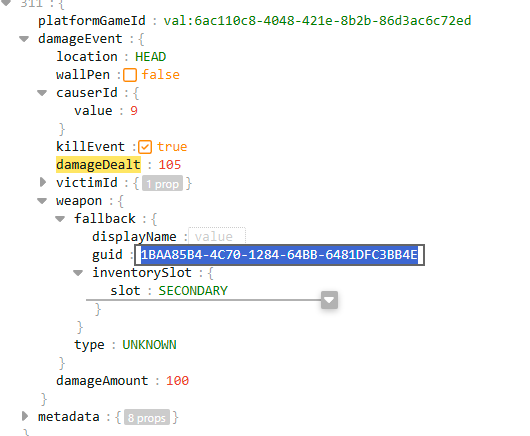

In [177]:
Image(filename='./images/damage_ghost.png')

In [178]:
df_damage_cleaned = pd.DataFrame(file_json['damageEvent'].dropna()) #only damage event
print_keys(df_damage_cleaned, 'damageEvent')


{'damageDealt', 'ability', 'killEvent', 'damageAmount', 'causerId', 'victimId', 'weapon', 'hazard', 'wallPen', 'location'}


### hazard 1 damage

1 damage hit can effect the calculation result about the HS rate

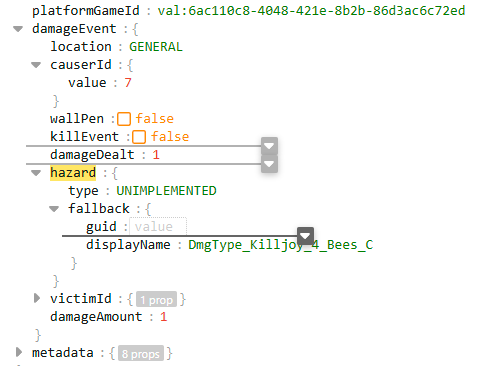

In [179]:
Image(filename='./images/1_damage.png')

Hazard 总共有出现 80次，其伤害类型为General。 但是General 总共出现113 次 

In [180]:
# 只选择包含 'hazard' 键的行
df_with_hazard = df_damage_cleaned[df_damage_cleaned['damageEvent'].apply(lambda x: 'hazard' in x)]

# 只选择不包含 'hazard' 键的行
df_without_hazard = df_damage_cleaned[df_damage_cleaned['damageEvent'].apply(lambda x: 'hazard' not in x)]

# 查看结果
print("Total Rows： ", df_damage_cleaned.shape[0])
print("Rows with 'hazard':", df_with_hazard.shape[0])

print("Rows without 'hazard':", df_without_hazard.shape[0])


Total Rows：  524
Rows with 'hazard': 76
Rows without 'hazard': 448


### location "GENERAL" analyse


In [181]:
count_unique_values(df_damage_cleaned, 'damageEvent', 'location')

{'BODY': 274, 'HEAD': 110, 'LEG': 27, 'GENERAL': 113}


In [182]:
df_with_location_general = df_damage_cleaned[df_damage_cleaned['damageEvent'].apply(lambda x: x['location'] == 'GENERAL')]
df_without_location_general = df_damage_cleaned[df_damage_cleaned['damageEvent'].apply(lambda x: x['location'] != 'GENERAL')]

print("Total Rows： ", df_damage_cleaned.shape[0])
print("Rows with location general:", df_with_location_general.shape[0])
print("Rows without location general:", df_without_location_general.shape[0])

Total Rows：  524
Rows with location general: 113
Rows without location general: 411


In [183]:
# 提取 causerID、victimID 和 damageAmount，减少重复 apply 操作
df_damage_cleaned[['causerID', 'victimID', 'damageAmount']] = df_damage_cleaned['damageEvent'].apply(
    lambda x: pd.Series({
        'causerID': x.get('causerId', {}).get('value', None),
        'victimID': x.get('victimId', {}).get('value', None),
        'damageAmount': x.get('damageAmount', 0)
    })
)

damage_taken_by_victim = df_damage_cleaned.groupby('victimID')['damageAmount'].sum().reset_index(name='totalDamageTaken')
damage_caused_by_causer = df_damage_cleaned.groupby('causerID')['damageAmount'].sum().reset_index(name='totalDamageCaused')
combined_data = damage_taken_by_victim.merge(damage_caused_by_causer, left_on='victimID', right_on='causerID', how='inner')

combined_data.head()

,victimID,totalDamageTaken,causerID,totalDamageCaused
0,1.0,1750.500000,1.0,1897.394734
1,2.0,1926.000002,2.0,2651.444491
2,3.0,1935.000128,3.0,2334.863821
3,4.0,1325.000003,4.0,1724.569281
4,5.0,1910.999997,5.0,2048.340864


In [184]:
# Create a new DataFrame from the 'damageEvent' column
damage_df = pd.json_normalize(df_with_location_general['damageEvent'])
# Count occurrences of each causerId
causer_id_counts = damage_df['causerId.value'].value_counts()
print("Causer ID counts:")
print(causer_id_counts)

# Distribution of damageDealt
print("Damage dealt distribution:")
print(damage_df['damageDealt'].value_counts())


Causer ID counts:
causerId.value
7    97
6    13
1     2
2     1
Name: count, dtype: int64
Damage dealt distribution:
damageDealt
1.000000      97
80.000000      2
730.000000     1
25.651459      1
61.439079      1
71.934593      1
61.249100      1
71.892273      1
75.000000      1
45.305046      1
45.493122      1
33.620262      1
49.038109      1
47.461868      1
42.055508      1
21.762571      1
Name: count, dtype: int64


!['730 general damage']('images/general_730_damage.png')
player id 6 sova 的两种伤害：
DmgType_Hunter_4_Molotov_C  爆炸箭造成的伤害 会造成这些带小数点的伤害
DmgType_Hunter_X_Laser_C 固定80点伤害

player id 7 的伤害：
DmgType_Killjoy_4_Bees_C 固定一点伤害

730 Outline

综上所述， location 为general的基本是技能伤害 (可用于技能效率, 后续分析)

In [209]:
fig = px.bar(
    combined_data,
    x='causerID',
    y=['totalDamageCaused', 'totalDamageTaken'],
    labels={
        "causerID": "Player ID",
        "value": "Count",
        "variable": "Metric"
    },
    # color = 'causerID',
    color_continuous_scale="Viridis",
    title="Damage and Kills for Each Player"
)

fig.update_layout(barmode='group')

fig.show()  


In [187]:
player_info_df['AverageDamagePerRound'] = combined_data['totalDamageCaused'].apply(lambda x: x / TOTAL_ROUND_NUM).apply(format_float)
player_info_df['AverageDamageTakenPerRound'] = combined_data['totalDamageTaken'].apply(lambda x: x / TOTAL_ROUND_NUM).apply(format_float)
player_info_df['DDDelta'] = (combined_data['totalDamageCaused'] - combined_data['totalDamageTaken']).apply(format_float)
player_info_df

,PlayerID,AgentName,TeamID,AverageDamagePerRound,AverageDamageTakenPerRound,DDDelta
0,1,Sova,19,111.61,102.97,8.64
1,2,Jett,19,155.97,113.29,42.67
2,3,Omen,19,137.34,113.82,23.52
3,4,Cypher,19,101.45,77.94,23.50
4,5,Kayo,19,120.49,112.41,8.08
5,6,Sova,18,138.42,118.27,20.15
6,7,Killjoy,18,122.77,103.88,18.89
7,8,Omen,18,46.44,111.76,-65.32
8,9,Jett,18,116.04,119.41,-3.37
9,10,Kayo,18,96.76,173.53,-76.77


In [188]:
df_without_location_general

,damageEvent
306,"{'location': 'BODY', 'causerId': {'value': 1},..."
311,"{'location': 'HEAD', 'wallPen': False, 'causer..."
343,"{'location': 'BODY', 'wallPen': False, 'causer..."
344,"{'location': 'HEAD', 'causerId': {'value': 5},..."
345,"{'location': 'BODY', 'wallPen': False, 'causer..."
...,...
6271,"{'location': 'BODY', 'wallPen': True, 'causerI..."
6272,"{'location': 'BODY', 'causerId': {'value': 1},..."
6273,"{'location': 'BODY', 'causerId': {'value': 1},..."
6279,"{'location': 'HEAD', 'wallPen': False, 'causer..."


## Head Shot Ratio
Formula: Number of bullets hitting the head of the enemy/number of bullets hitting the enemy

In [208]:
# 使用一次 apply 处理多个字段
df_without_location_general[['causerID', 'isHeadShot', 'damageAmount']] = df_without_location_general['damageEvent'].apply(
    lambda x: pd.Series({
        'causerID': x.get('causerId', {}).get('value', None),
        'isHeadShot': x.get('location') == 'HEAD',
        'damageAmount': x.get('damageAmount', 0)
    })
)

# 统计每个玩家击中头部的次数
headshot_hits = df_without_location_general.groupby('causerID')['isHeadShot'].sum().reset_index(name='headshotHits')

# 统计每个玩家的总击中次数
total_hits = df_without_location_general.groupby('causerID').size().reset_index(name='totalHits')

player_hs_stats = pd.merge(headshot_hits, total_hits, on='causerID', how='outer')

player_hs_stats['headshotHitRate'] = (player_hs_stats['headshotHits'] / player_hs_stats['totalHits'] * 100).round(2)

player_info_df['HeadshotRate'] = player_hs_stats['headshotHitRate']

player_info_df

C:\Users\chao\AppData\Local\Temp\ipykernel_17312\3991179110.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,PlayerID,AgentName,TeamID,AverageDamagePerRound,AverageDamageTakenPerRound,DDDelta,HeadshotRate
0,1,Sova,19,111.61,102.97,8.64,33.33
1,2,Jett,19,155.97,113.29,42.67,25.00
2,3,Omen,19,137.34,113.82,23.52,23.53
3,4,Cypher,19,101.45,77.94,23.50,14.89
4,5,Kayo,19,120.49,112.41,8.08,26.83
5,6,Sova,18,138.42,118.27,20.15,20.45
6,7,Killjoy,18,122.77,103.88,18.89,30.00
7,8,Omen,18,46.44,111.76,-65.32,16.67
8,9,Jett,18,116.04,119.41,-3.37,36.36
9,10,Kayo,18,96.76,173.53,-76.77,39.39


In [190]:
fig = px.bar(
    player_hs_stats,
    x='causerID',
    y=['headshotHits', 'totalHits', 'headshotHitRate'],
    labels={
        "causerID": "Player ID",
        "value": "Count",
        "variable": "Metric"
    },
    color_continuous_scale="Viridis",
    title="HS hit and total hit for Each Player"
)

fig.update_layout(barmode='group')

fig.show()

In [191]:
player_info_df

,PlayerID,AgentName,TeamID,AverageDamagePerRound,AverageDamageTakenPerRound,DDDelta,HeadshotRate
0,1,Sova,19,111.61,102.97,8.64,33.33
1,2,Jett,19,155.97,113.29,42.67,25.00
2,3,Omen,19,137.34,113.82,23.52,23.53
3,4,Cypher,19,101.45,77.94,23.50,14.89
4,5,Kayo,19,120.49,112.41,8.08,26.83
5,6,Sova,18,138.42,118.27,20.15,20.45
6,7,Killjoy,18,122.77,103.88,18.89,30.00
7,8,Omen,18,46.44,111.76,-65.32,16.67
8,9,Jett,18,116.04,119.41,-3.37,36.36
9,10,Kayo,18,96.76,173.53,-76.77,39.39


In [206]:
# df_damage_cleaned['weaponGUID'] = df_damage_cleaned['damageEvent'].apply(lambda x: x.get('weapon', {}).get('fallback', {}).get('guid'))

df_without_location_general['weaponGUID'] = df_without_location_general['damageEvent'].apply(lambda x: x.get('weapon', {}).get('fallback', {}).get('guid', 'UNKNOWN'))
df_without_location_general['weaponName'] = df_without_location_general['weaponGUID'].map(GUID_DISPLAYNAME_DICT)
# UNKNOWN guid is empty. "slot": "MELEE" ( 用匕首造成了伤害 )
# 1. 统计每个玩家使用武器造成最多次的伤害
most_used_weapon = df_without_location_general.groupby(['causerID', 'weaponName']).size().reset_index(name='weaponUsage')
most_used_weapon = most_used_weapon.loc[most_used_weapon.groupby('causerID')['weaponUsage'].idxmax()]

# 查看结果：玩家常用武器和武器统计
print(most_used_weapon)


    causerID weaponName  weaponUsage
0          1    Bulldog           14
7          2      Judge           10
17         3     Vandal           35
21         4     Vandal           31
26         5     Vandal           16
31         6     Vandal           30
34         7     Vandal           34
38         8     Vandal           11
46         9     Vandal           16
47        10    Classic           18


C:\Users\chao\AppData\Local\Temp\ipykernel_17312\3542790112.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\chao\AppData\Local\Temp\ipykernel_17312\3542790112.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [193]:
df_without_location_general.head()

,damageEvent,causerID,isHeadShot,damageAmount,weaponGUID,weaponName
306,"{'location': 'BODY', 'causerId': {'value': 1},...",1,False,30.000000,1BAA85B4-4C70-1284-64BB-6481DFC3BB4E,Ghost
311,"{'location': 'HEAD', 'wallPen': False, 'causer...",9,True,100.000000,1BAA85B4-4C70-1284-64BB-6481DFC3BB4E,Ghost
343,"{'location': 'BODY', 'wallPen': False, 'causer...",5,False,30.000000,1BAA85B4-4C70-1284-64BB-6481DFC3BB4E,Ghost
344,"{'location': 'HEAD', 'causerId': {'value': 5},...",5,True,97.844711,1BAA85B4-4C70-1284-64BB-6481DFC3BB4E,Ghost
345,"{'location': 'BODY', 'wallPen': False, 'causer...",5,False,30.000000,1BAA85B4-4C70-1284-64BB-6481DFC3BB4E,Ghost


In [194]:
# 创建不同玩家的饼图
fig = go.Figure()

# 为每个玩家创建饼图数据
players = df_without_location_general['causerID'].unique()
for player in players:
    player_data = df_without_location_general[df_without_location_general['causerID'] == player]
    fig.add_trace(go.Pie(labels=player_data['weaponName'], 
                         values=player_data['damageAmount'], 
                         visible=(player == players[0]),  # 仅默认显示第一个玩家的图
                         name=f'Player {player}'))

# 创建下拉按钮
buttons = []
for i, player in enumerate(players):
    buttons.append(dict(method='update',
                        label=f"Player {player}",
                        args=[{'visible': [False] * len(players)},  # 隐藏其他玩家的数据
                              {'title': f"Weapon Damage Distribution for Player {player}"}]))
    buttons[-1]['args'][0]['visible'][i] = True  # 仅显示当前选择玩家的饼图

# 添加按钮到图表中
fig.update_layout(updatemenus=[{
    'buttons': buttons,
    'direction': 'down',
    'showactive': True
}])

fig.update_layout(title_text="Weapon Damage Distribution for Players")


fig.add_trace(go.Pie(labels=player_data['weaponName'], 
                     values=player_data['damageAmount'], 
                     visible=(player == players[0]), 
                     name=f'Player {player}'))

# 显示图表
fig.show()

In [211]:
weapon_usage = df_without_location_general.groupby(['causerID', 'weaponName'])['damageAmount'].sum().reset_index()

# 计算每个玩家的总伤害
total_damage_per_player = weapon_usage.groupby('causerID')['damageAmount'].sum().reset_index(name='totalDamage')

# 合并总伤害到 weapon_usage 中
weapon_usage = weapon_usage.merge(total_damage_per_player, on='causerID')

# 计算玩家对每个武器的使用比例
weapon_usage['weaponProficiency'] = (weapon_usage['damageAmount'] / weapon_usage['totalDamage'] * 100).round(2)

# 获取每个玩家使用最多的武器和该武器的使用比例
most_used_weapon = weapon_usage.loc[weapon_usage.groupby('causerID')['damageAmount'].idxmax(), ['causerID', 'weaponName', 'weaponProficiency']]

# 将信息合并到 player_info_df 中
player_info_df = player_info_df.merge(most_used_weapon, left_on='PlayerID', right_on='causerID', how='left')

# 重命名新列
player_info_df.rename(columns={'weaponName': 'MostUsedWeapon', 'weaponProficiency': 'MostUsedWeaponProficiency'}, inplace=True)

# 删除冗余的 causerID 列
player_info_df = player_info_df.drop(columns=['causerID'])

# 显示最终的 DataFrame
player_info_df


,PlayerID,AgentName,TeamID,AverageDamagePerRound,AverageDamageTakenPerRound,DDDelta,HeadshotRate,MostUsedWeapon,MostUsedWeaponProficiency,MostUsedWeapon,MostUsedWeaponProficiency
0,1,Sova,19,111.61,102.97,8.64,33.33,Vandal,48.14,Vandal,48.14
1,2,Jett,19,155.97,113.29,42.67,25.00,Operator,29.01,Operator,29.01
2,3,Omen,19,137.34,113.82,23.52,23.53,Vandal,76.07,Vandal,76.07
3,4,Cypher,19,101.45,77.94,23.50,14.89,Vandal,73.37,Vandal,73.37
4,5,Kayo,19,120.49,112.41,8.08,26.83,Vandal,44.63,Vandal,44.63
5,6,Sova,18,138.42,118.27,20.15,20.45,Vandal,82.60,Vandal,82.60
6,7,Killjoy,18,122.77,103.88,18.89,30.00,Vandal,85.89,Vandal,85.89
7,8,Omen,18,46.44,111.76,-65.32,16.67,Vandal,69.83,Vandal,69.83
8,9,Jett,18,116.04,119.41,-3.37,36.36,Vandal,40.65,Vandal,40.65
9,10,Kayo,18,96.76,173.53,-76.77,39.39,Classic,51.56,Classic,51.56


In [205]:
# Average weapon damage
def avg_visualization(df, name="Damage", name2="Players"):
    # Calculate average damage per weapon
    avg_damage_df = df.groupby('weaponName')['damageAmount'].mean().reset_index().sort_values(by='damageAmount', ascending=False)

    # Plot the average damage
    fig = px.bar(avg_damage_df, x='weaponName', y='damageAmount', color='damageAmount', color_continuous_scale="Viridis")
    fig.update_layout(
        title={'text': f"Average {name} by {name2}", 'x': 0.5},
        xaxis_title="Weapons",
        yaxis_title=f"{name}",
        showlegend=False
    )
    fig.show()

avg_visualization(df_without_location_general, 'Damage', 'Weapon')


## ACS (Average Combat Score) 

1. Damage: +1 ACS / 1 dmg dealt

2. Kills (based on enemies alive): +150 / 130 / 110 / 90 / 70

3. Multikills: +50 per additional kill

4. Non-damaging assists (ie. blinded enemy dies) : +25 each 

Score Calculation of the second condition:
+150 when the player numbers are even (getting a kill in a 5v5, 4v4, 3v3, etc.) 

+130 when the player numbers have a difference of 1 (getting a kill in a 5v4, 3v4, 3v2, etc.)

+110 when the player numbers have a difference of 2 (getting a kill in a 5v3, 3v5, 3v1, etc.)

+90 when the player numbers have a difference of 3 (getting a kill in a 5v2, 2v5, 4v1, etc.)

+70 when the player numbers have a difference of 4 (getting a kill in a 5v1 or 1v5)

Getting more kill points when there are equal numbers of players.
Getting a kill in 1v5 doesn't have much impact (the opponent may be bloodied, and the rewards are richer for consecutive kills, so the base score will be lower.

Reference: https://www.reddit.com/r/VALORANT/comments/zjkmyk/a_better_way_to_calculate_acs_average_combat_score/

Formula: acs_scores = (Damage dealt per round * 1 + Enemies killed * Specific number difference case + Kill streaks * 50 + Assists * 25) / Number of rounds


In [233]:
player_data_list = []
snapshot_data = pd.read_json('output_file.json')['snapshot'].dropna()
player_result_data = snapshot_data.iloc[-1]['players']

for player in player_result_data:
    player_data_list.append({
        'PlayerID': player['playerId']['value'],
        'CombatScore': player['scores']['combatScore']['totalScore'],
        'AverageCombatScore': format_float(player['scores']['combatScore']['totalScore'] / TOTAL_ROUND_NUM, 2),
        'Kills': player.get('kills', 0),
        'Deaths': player.get('deaths', 0),
        'Assists': player.get('assists', 0),
        '+-': player.get('kills', 0) - player.get('deaths', 0),
        'KPR': format_float(player.get('kills', 0) / TOTAL_ROUND_NUM, 2),
        'DPR': format_float(player.get('deaths', 0) / TOTAL_ROUND_NUM, 2),   
    })


player_merged_info_df = pd.merge(player_info_df, pd.DataFrame(player_data_list), on='PlayerID', how='inner')
# Create the bar chart using plotly
fig = go.Figure(data=[
    go.Bar(x=player_merged_info_df['PlayerID'], y=player_merged_info_df['CombatScore'], text=player_merged_info_df['CombatScore'], textposition='auto')
])

# Set chart title and labels
fig.update_layout(
    title="Player Combat Scores",
    xaxis_title="Player ID",
    yaxis_title="Total Combat Score",
)

# Show the figure
fig.show()
player_merged_info_df

,PlayerID,AgentName,TeamID,AverageDamagePerRound,AverageDamageTakenPerRound,DDDelta,HeadshotRate,MostUsedWeapon,MostUsedWeaponProficiency,MostUsedWeapon,MostUsedWeaponProficiency,CombatScore,AverageCombatScore,Kills,Deaths,Assists,+-,KPR,DPR
0,1,Sova,19,111.61,102.97,8.64,33.33,Vandal,48.14,Vandal,48.14,3861,227.12,15,10,4,5,0.88,0.59
1,2,Jett,19,155.97,113.29,42.67,25.00,Operator,29.01,Operator,29.01,3956,232.71,15,14,1,1,0.88,0.82
2,3,Omen,19,137.34,113.82,23.52,23.53,Vandal,76.07,Vandal,76.07,4696,276.24,17,13,19,4,1.00,0.76
3,4,Cypher,19,101.45,77.94,23.50,14.89,Vandal,73.37,Vandal,73.37,3605,212.06,14,10,3,4,0.82,0.59
4,5,Kayo,19,120.49,112.41,8.08,26.83,Vandal,44.63,Vandal,44.63,4258,250.47,16,10,13,6,0.94,0.59
5,6,Sova,18,138.42,118.27,20.15,20.45,Vandal,82.60,Vandal,82.60,4499,264.65,15,15,6,0,0.88,0.88
6,7,Killjoy,18,122.77,103.88,18.89,30.00,Vandal,85.89,Vandal,85.89,4742,278.94,19,14,1,5,1.12,0.82
7,8,Omen,18,46.44,111.76,-65.32,16.67,Vandal,69.83,Vandal,69.83,1293,76.06,3,16,11,-13,0.18,0.94
8,9,Jett,18,116.04,119.41,-3.37,36.36,Vandal,40.65,Vandal,40.65,3838,225.76,13,16,0,-3,0.76,0.94
9,10,Kayo,18,96.76,173.53,-76.77,39.39,Classic,51.56,Classic,51.56,2753,161.94,7,16,11,-9,0.41,0.94


In [ ]:
# 结论： Combat Score 只能作为评判玩家游戏表现，不符合定位要求
# 不同角色区分不同定位，不同角色使用技能情况 经济情况 和 武器情况
# https://www.kaggle.com/code/rakeshkudmulwar7/valorant-champions-2024-masters-madrid
# 缺乏玩家的个人信息，比如年龄 性别，只能通过局内表现来进行分析

# 根据选手决胜局的表现 对比平时数据来显示选手性格
# 选手平时表现：稳定或者状态有起伏
# 选手决胜局表现：相信还是怀疑自己
# 选手劣势局表现：差还是xx

In [ ]:
# 从生涯分析和队友的配合程度以及对局胜率
# 最后一把的操作
# 第一把的操作

# 常见指标 #

Data related to the timeseries (wall time)
FK： 首杀（难）
FD： 首死（难）
MK： 多杀，单人三杀 三杀以上回合数（难）
KAST (Kill, Assist, Survive, Trade)：击杀、助攻、存活、换人（击中后阵亡，队友短时间内击杀敌人）的综合百分比。
KAST=  K+A+S+T / TOTAL_ROUND_NUM ×100
KAST 代表玩家在这些条件中的达成情况，通常以百分比的形式表示。
常数确保基础评分不会过低

R(Rating) 参考cs2 的rating公式  HLTV Rating 2.0： rating = 0.3591 * KPR - 0.5329 * DPR + 0.2372 * Impact rating (影响评分——首杀，决定性回合中的表现。) + 0.0032 * ADR + 0.0073 * KAST + 0.1587
> 1.1 carry 表现
  0.9~1.1 正常
< 0.9 表现差


# 根据对局的时间轴描述成员的金币总量和武器变化

# 根据数据区分玩家的游戏定位（辅助，副c，主C）

# 最近几场比赛选手的表现变化

## Gold Used (正确的时机进行保存或者豪华购买)
Analyzing economic decisions in terms of spending on weapons and armor versus winning rounds can provide insights into optimal buy strategies. Data on "eco rounds" or "half buys" and their success rates is also significant.

In [214]:
df_transaction_cleaned = pd.DataFrame(file_json['inventoryTransaction'].dropna())
df_transaction_cleaned['playerID'] = df_transaction_cleaned['inventoryTransaction'].apply(lambda x: x['player']['value'])
df_transaction_cleaned['transactionType'] = df_transaction_cleaned['inventoryTransaction'].apply(lambda x: x['transactionType'])
df_transaction_cleaned

,inventoryTransaction,playerID,transactionType
41,"{'player': {'value': 5}, 'weapon': {'fallback'...",5,DROP
42,"{'player': {'value': 5}, 'weapon': {'fallback'...",5,PURCHASE
43,"{'player': {'value': 5}, 'ability': {'type': '...",5,PURCHASE
45,"{'player': {'value': 2}, 'weapon': {'fallback'...",2,DROP
46,"{'player': {'value': 2}, 'weapon': {'fallback'...",2,PURCHASE
...,...,...,...
5942,"{'player': {'value': 5}, 'weapon': {'type': 'U...",5,SELL
5943,"{'player': {'value': 5}, 'weapon': {'fallback'...",5,TRASH
5944,"{'player': {'value': 5}, 'weapon': {'fallback'...",5,PURCHASE
5959,"{'player': {'value': 4}, 'weapon': {'type': 'U...",4,PURCHASE


In [231]:
# 提取每次交易的物品类型
def get_purchase_type(transaction):
    if transaction['transactionType'] == 'PURCHASE':       
        if 'weapon' in transaction and transaction['weapon']['fallback']['guid']:
            return 'weapon'
        elif 'ability' in transaction and transaction['ability']['type']:
            return 'ability'
        elif 'armor' in transaction:
            return 'armor'
        else:
            return 'other'

df_transaction_cleaned['purchase_type'] = df_transaction_cleaned['inventoryTransaction'].apply(get_purchase_type)

purchase_stats = df_transaction_cleaned.groupby(['playerID', 'purchase_type']).size().reset_index(name='count').dropna()
print(purchase_stats.head())

fig = px.bar(purchase_stats, x='purchase_type', y='count', color='playerID', 
             facet_col='playerID', 
             labels={'chargesConsumed':'Charges Consumed', 'ability':'Ability', 'playerID':'Player ID'},
             # color_continuous_scale="Viridis",
             title='Total Ability Usage by Player',
             height=600)

fig.show()

    

   playerID purchase_type  count
0         1       ability      1
1         1         armor     15
2         1        weapon     11
3         2       ability      1
4         2         armor     14


In [232]:
df_transaction_cleaned['purchase_type'] = df_transaction_cleaned['inventoryTransaction'].apply(get_purchase_type)

purchase_stats = df_transaction_cleaned.groupby(['playerID', 'transactionType']).size().reset_index(name='count').dropna()
print(purchase_stats.head())

fig = px.bar(purchase_stats, x='transactionType', y='count', color='playerID', 
             facet_col='playerID', 
             labels={'chargesConsumed':'Charges Consumed', 'ability':'Ability', 'playerID':'Player ID'},
             # color_continuous_scale="Viridis",
             title='Player\'s  Action',
             height=600)

fig.show()

   playerID  transactionType  count
0         1          DEFAULT      4
1         1             DROP      1
2         1  FULFILL_REQUEST      3
3         1            OTHER      9
4         1          PICK_UP      2


In [234]:
print(count_unique_values(df_transaction_cleaned, 'inventoryTransaction', 'transactionType'))

{'DROP': 12, 'PURCHASE': 353, 'PICK_UP': 61, 'TRANSFER': 27, 'OTHER': 150, 'SELL': 16, 'TRASH': 4, 'FULFILL_REQUEST': 19, 'DEFAULT': 40}
None


高频交易玩家（如 Player 3 和 Player 9）似乎在比赛中更注重物资的调配和管理。
交易类型分布显示 TRANSFER 是游戏中最常见的交易类型，表明物资转移在比赛策略中占据重要地位。
进一步的分析可以关注不同交易类型与玩家胜率之间的潜在联系，帮助更好地理解这些交易行为如何影响游戏结果

Analyzing economic decisions in terms of spending on weapons and armor versus winning rounds can provide insights into optimal buy strategies. Data on "eco rounds" or "half buys" and their success rates is also significant.

In [ ]:
# 手枪局的金钱使用和伤害（方便快速滚雪球）

### Risk-Taking Players: Players with high fluctuation in money (e.g., Player 2 and Player 7) might be risk-takers, making bigger purchases or banking on winning.
### Conservative Players: Players with more steady changes might be saving more or spending cautiously


# Ability Used
Valorant's focus on abilities means that analyzing ability impact is essential for understanding player value beyond shooting skills.

In [219]:
df_ability_used = pd.DataFrame(file_json['abilityUsed'].dropna())
df_ability_used.head()

,abilityUsed
97,"{'chargesConsumed': 1, 'ability': {'fallback':..."
99,"{'chargesConsumed': 1, 'ability': {'fallback':..."
104,"{'chargesConsumed': 1, 'ability': {'fallback':..."
112,"{'chargesConsumed': 1, 'ability': {'fallback':..."
117,"{'chargesConsumed': 1, 'ability': {'fallback':..."


In [220]:
print_keys(df_ability_used, 'abilityUsed')


{'chargesConsumed', 'playerId', 'ability'}


In [221]:
print_all_keys(df_ability_used, 'abilityUsed')

{'value', 'inventorySlot', 'displayName', 'chargesConsumed', 'type', 'guid', 'fallback', 'playerId', 'ability', 'slot'}


{'ability',
 'chargesConsumed',
 'displayName',
 'fallback',
 'guid',
 'inventorySlot',
 'playerId',
 'slot',
 'type',
 'value'}

In [222]:
count_unique_values(df_ability_used, 'abilityUsed', 'chargesConsumed')

{1: 626, 2: 2}


In [223]:
df_ability_used['playerID']  = df_ability_used['abilityUsed'].apply(lambda x: x.get('playerId', {}).get('value', {}))
df_ability_used['ability']  = df_ability_used['abilityUsed'].apply(lambda x: x.get('ability', {}).get('fallback', {}).get('inventorySlot', {}).get('slot', {}))
df_ability_used['chargesConsumed']  = df_ability_used['abilityUsed'].apply(lambda x: x.get('chargesConsumed', {}))

In [224]:
df_ability_used.head()

,abilityUsed,playerID,ability,chargesConsumed
97,"{'chargesConsumed': 1, 'ability': {'fallback':...",4,ABILITY_2,1
99,"{'chargesConsumed': 1, 'ability': {'fallback':...",7,ABILITY_2,1
104,"{'chargesConsumed': 1, 'ability': {'fallback':...",4,ABILITY_2,1
112,"{'chargesConsumed': 1, 'ability': {'fallback':...",7,GRENADE_ABILITY,1
117,"{'chargesConsumed': 1, 'ability': {'fallback':...",4,GRENADE_ABILITY,1


In [225]:
stat = df_ability_used.groupby(['playerID', 'ability'], group_keys=True).agg({'chargesConsumed' : 'sum'}).reset_index()
stat.head() 

,playerID,ability,chargesConsumed
0,1,ABILITY_1,12
1,1,ABILITY_2,33
2,1,GRENADE_ABILITY,13
3,1,ULTIMATE,2
4,2,ABILITY_1,7


In [226]:

fig = px.bar(stat, x='ability', y='chargesConsumed', color='playerID', 
             facet_col='playerID', 
             labels={'chargesConsumed':'Charges Consumed', 'ability':'Ability', 'playerID':'Player ID'},
             # color_continuous_scale="Viridis",
             title='Total Ability Usage by Player',
             height=600, width=2000)

fig.show()


还有玩家通过技能获得助攻的比率
技能使用频率：反映玩家是否善于利用角色技能。
技能影响力：例如，玩家是否通过技能获得助攻，或者影响敌方的行为。

# Spike location

Understanding how teams coordinate for spike plants or retakes, and analyzing timing and positioning during these phases, helps teams refine their overall game strategy.

. **Map Control and Heat Maps**: Data on player movement, kills, and death locations provide a visual representation of which areas of the map are contested more often. This analysis helps identify strategies for map control, choke points, and key spike plant sites. To analyze heat maps based on XYZ information, you can use positional data of players and events to generate visual representations. Tools like GIS software or custom scripts can help visualize high-density areas, indicating hotspots for engagements or spike plants. Geographic Information Systems (GIS) can be particularly useful in providing spatial analysis, such as determining popular movement paths, clustering player death locations, and analyzing areas of map control throughout a match.

In [240]:
df_spike_loc_clean = pd.DataFrame(file_json['spikePlantCompleted']).dropna()

# Extract 'x', 'y' coordinates and 'playerId'
df_spike_loc_clean['x'] = df_spike_loc_clean['spikePlantCompleted'].apply(lambda loc: loc['plantLocation']['x'])
df_spike_loc_clean['y'] = df_spike_loc_clean['spikePlantCompleted'].apply(lambda loc: loc['plantLocation']['y'])
df_spike_loc_clean['z'] = df_spike_loc_clean['spikePlantCompleted'].apply(lambda loc: loc['plantLocation']['z'])
df_spike_loc_clean['playerId'] = df_spike_loc_clean['spikePlantCompleted'].apply(lambda loc: loc['playerId']['value'])

fig = px.scatter(df_spike_loc_clean, 
                    x='x', 
                    y='y', 
                    color='playerId', 
                    labels={'x': 'X Coordinate', 'y': 'Y Coordinate', 'z': 'Z Coordinate', 'playerId': 'Player ID'},
                    title='Spike Plant Locations by Player in 3D')

fig.show()

In [241]:
df_spike_loc_clean

,spikePlantCompleted,x,y,z,playerId
976,"{'plantLocation': {'y': -8185.40332, 'x': -344...",-3440.69702,-8185.40332,-103.727417,6
1302,"{'plantLocation': {'y': -7219.21, 'x': -3806.1...",-3806.17944,-7219.21000,-103.901459,7
1720,"{'plantLocation': {'y': -7683.85, 'x': 6155.56...",6155.56738,-7683.85000,500.000000,10
3097,"{'plantLocation': {'y': -6676.40625, 'x': 5467...",5467.35449,-6676.40625,500.000000,6
3447,"{'plantLocation': {'y': -6755.8335, 'x': 5504....",5504.87695,-6755.83350,502.150208,10
4466,"{'plantLocation': {'y': -7573.48, 'x': -3292.4...",-3292.45190,-7573.48000,-94.637009,5
4896,"{'plantLocation': {'y': -7546.26855, 'x': -328...",-3281.35059,-7546.26855,-95.555969,3
5291,"{'plantLocation': {'y': -6883.79932, 'x': -397...",-3970.85889,-6883.79932,-82.810623,5
5853,"{'plantLocation': {'y': -6878.1416, 'x': -3972...",-3972.12280,-6878.14160,-81.614120,5
6168,"{'plantLocation': {'y': -6876.46973, 'x': -397...",-3970.17554,-6876.46973,-81.491928,5


# Spike Transfer

Understanding the success rates of different plays (e.g., rush B, slow default, split A) can help teams refine their tactics. Data on how teams adapt during different halves and readjust their strategies in real-time is also significant.

In [237]:
df_spike_clean = pd.DataFrame(file_json['spikeStatus']).dropna()
print_keys(df_spike_clean, 'spikeStatus')

df_spike_clean['carrier'] = df_spike_clean['spikeStatus'].apply(lambda x: x.get('carrier', {}).get('value', None))
df_spike_clean['status'] = df_spike_clean['spikeStatus'].apply(lambda x: x.get('status', None))
df_spike_clean

{'carrier', 'status'}


,spikeStatus,carrier,status
32,{'status': 'SPAWNED'},NaN,SPAWNED
49,"{'carrier': {'value': 10}, 'status': 'IN_HANDS'}",10.0,IN_HANDS
235,{'status': 'ON_GROUND'},NaN,ON_GROUND
236,"{'carrier': {'value': 6}, 'status': 'IN_HANDS'}",6.0,IN_HANDS
353,{'status': 'ON_GROUND'},NaN,ON_GROUND
...,...,...,...
5865,{'status': 'NOT_SPAWNED'},NaN,NOT_SPAWNED
5885,{'status': 'SPAWNED'},NaN,SPAWNED
5894,"{'carrier': {'value': 5}, 'status': 'IN_HANDS'}",5.0,IN_HANDS
6167,"{'carrier': {'value': 5}, 'status': 'PLANTED'}",5.0,PLANTED


In [216]:
spike_status = list(set(df_spike_clean['status']))
print(spike_status)
spike_status = ['SPAWNED', 'IN_HANDS', 'ON_GROUND', 'PLANTED', 'DEFUSED', 'NOT_SPAWNED'] # reorder

['PLANTED', 'IN_HANDS', 'NOT_SPAWNED', 'ON_GROUND', 'DEFUSED', 'SPAWNED']


In [217]:
# 提取 status 字段
df_spike_clean['status'] = df_spike_clean['spikeStatus'].apply(lambda x: x.get('status', None))
df_spike_clean['carrier'] = df_spike_clean['spikeStatus'].apply(lambda x: x.get('carrier', {}).get('value', {}))

# 通过 'SPAWNED' 和 'NOT_SPAWNED' 状态标记每局的开始和结束
game_rounds = []
current_round = []
in_round = False

for idx, row in df_spike_clean.iterrows():
    if row['status'] == 'SPAWNED':
        if in_round:  # 如果当前在对局中，且再次遇到 SPAWNED，意味着上局结束
            game_rounds.append(current_round)
        current_round = [row]  # 新对局开始
        in_round = True
    elif row['status'] == 'NOT_SPAWNED':
        current_round.append(row)  # 记录对局结束状态
        game_rounds.append(current_round)  # 结束当前对局
        in_round = False  # 标记不再处于对局中
    else:
        if in_round:  # 如果在对局中，记录当前状态
            current_round.append(row)
# 分析每局中炸弹的状态变化
for i, game_round in enumerate(game_rounds):
    print(f"Game round {i}:")
    for event in game_round:
        status = event.get('status')
        carrier = event.get('carrier', {})
        print(f" - Status: {status}, Carrier: {carrier}")
    planted = any(event['status'] == 'PLANTED' for event in game_round)
    carriers = set(event.get('carrier', {}) for event in game_round if event.get('carrier'))
    print(f" - Bomb Planted: {'Yes' if planted else 'No'}")
    print(f" - Carriers: {carriers}")


Game round 0:
 - Status: SPAWNED, Carrier: {}
 - Status: IN_HANDS, Carrier: 10
 - Status: ON_GROUND, Carrier: {}
 - Status: IN_HANDS, Carrier: 6
 - Status: ON_GROUND, Carrier: {}
 - Status: IN_HANDS, Carrier: 8
 - Status: ON_GROUND, Carrier: {}
 - Status: NOT_SPAWNED, Carrier: {}
 - Bomb Planted: No
 - Carriers: {8, 10, 6}
Game round 1:
 - Status: SPAWNED, Carrier: {}
 - Status: IN_HANDS, Carrier: 6
 - Status: ON_GROUND, Carrier: {}
 - Status: NOT_SPAWNED, Carrier: {}
 - Bomb Planted: No
 - Carriers: {6}
Game round 2:
 - Status: SPAWNED, Carrier: {}
 - Status: IN_HANDS, Carrier: 10
 - Status: ON_GROUND, Carrier: {}
 - Status: IN_HANDS, Carrier: 6
 - Status: PLANTED, Carrier: 6
 - Status: NOT_SPAWNED, Carrier: {}
 - Bomb Planted: Yes
 - Carriers: {10, 6}
Game round 3:
 - Status: SPAWNED, Carrier: {}
 - Status: IN_HANDS, Carrier: 7
 - Status: ON_GROUND, Carrier: {}
 - Status: IN_HANDS, Carrier: 6
 - Status: ON_GROUND, Carrier: {}
 - Status: IN_HANDS, Carrier: 7
 - Status: PLANTED, Carrie

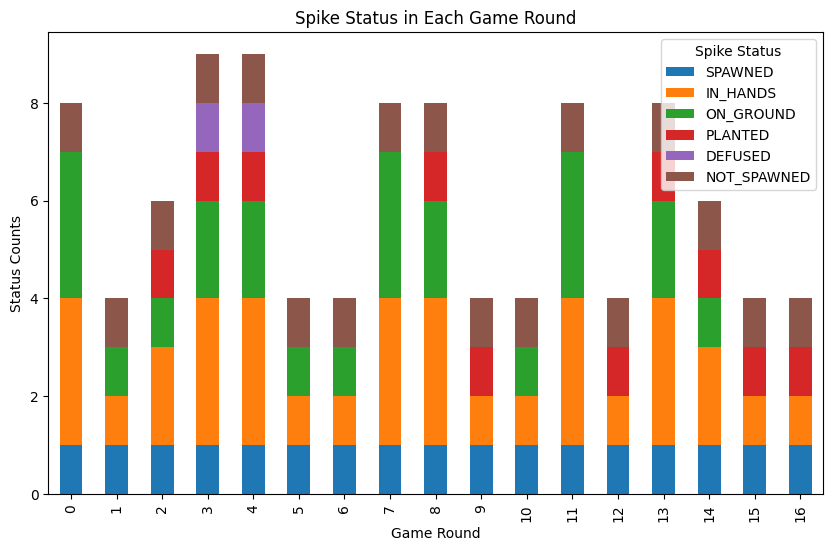

In [218]:
import matplotlib.pyplot as plt

# 准备数据：统计每局游戏中每个状态的次数
status_counts_per_round = []
for i, game_round in enumerate(game_rounds):
    status_counts = {status: 0 for status in spike_status}  # 初始化每个状态为 0
    for event in game_round:
        status = event.get('status')
        if status in status_counts:  # 确保 status 是有效的
            status_counts[status] += 1
    status_counts_per_round.append(status_counts)

# 转换为 DataFrame 方便绘制
df_status_counts = pd.DataFrame(status_counts_per_round)

# 绘制堆叠柱状图
df_status_counts.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.xlabel('Game Round')
plt.ylabel('Status Counts')
plt.title('Spike Status in Each Game Round')
plt.legend(title="Spike Status")
plt.show()


In [238]:
# position 
# The importance of coordinated pushes and rotations is evident in both games, making it necessary to analyze timing, positioning, and coordination data for both team performance and strategic adjustments.


## 通过是歼灭敌人获得胜利还是安放炸弹成功爆炸获得胜利 来判断玩家水平

高比例歼灭胜利的玩家：这些玩家的枪法和正面对抗能力可能很强，战斗意识较高。
高比例炸弹胜利的玩家：这些玩家可能有更强的团队协作能力和战略意识，能够在需要时执行复杂的任务。
均衡的玩家：这种玩家可以在不同的场景下表现出色，具有适应性和全面的能力

1. 歼灭敌人获得胜利的玩家
如果一个玩家或团队通过歼灭敌人来获得胜利，可以表明以下几方面的技能：

射击技巧：通过消灭所有敌人赢得比赛，说明该玩家的瞄准能力、反应速度、地图控制等方面都比较强。
对抗性：这些玩家可能更加擅长与敌人正面作战，利用枪法和战术来消灭敌人。
进攻和防守策略：通过消灭敌人获得胜利可能表明玩家对地图的理解和对时机的把握非常好，能够有效地进行压制或防守。
2. 通过安放炸弹获得胜利的玩家
如果一个玩家或团队通过成功安放炸弹并引爆获得胜利，这可以表明以下几方面的技能：

战术配合：成功安放炸弹通常需要团队协作，包括掩护队友、控制爆破点等。这表明该玩家或团队的协作能力很强。
战略思维：这些玩家往往会更重视游戏中的战略层面，例如利用地形优势，选择合适的爆破点，执行炸弹安装和防守策略。
时间管理和目标意识：炸弹引爆有时间限制，因此能够成功引爆炸弹的玩家通常对时间管理有较强的意识，懂得如何压制敌人并有效地防守炸弹。
3. 混合胜利方式的玩家
有些玩家可能通过混合两种方式（消灭敌人和炸弹引爆）来获得胜利，这可以表明该玩家的多面性：

灵活性：能够根据场上局势选择不同的胜利途径，表明该玩家的战术适应能力强，能够快速作出有效的决策。
全面性：这类玩家在射击技巧和战略思维上都有一定的优势，能够在不同的情况下作出合适的选择。

{'state': 'WINNER_DECIDED', 'winningTeam': {'value': 19}, 'spikeMode': {'currentRound': 17, 'attackingTeam': {'value': 19}, 'completedRounds': [{'roundNumber': 1, 'spikeModeResult': {'attackingTeam': {'value': 18}, 'cause': 'ELIMINATION', 'defendingTeam': {'value': 19}}, 'winningTeam': {'value': 19}}, {'roundNumber': 2, 'spikeModeResult': {'attackingTeam': {'value': 18}, 'cause': 'ELIMINATION', 'defendingTeam': {'value': 19}}, 'winningTeam': {'value': 19}}, {'roundNumber': 3, 'spikeModeResult': {'attackingTeam': {'value': 18}, 'cause': 'ELIMINATION', 'defendingTeam': {'value': 19}}, 'winningTeam': {'value': 18}}, {'roundNumber': 4, 'spikeModeResult': {'attackingTeam': {'value': 18}, 'cause': 'SPIKE_DEFUSE', 'defendingTeam': {'value': 19}}, 'winningTeam': {'value': 19}}, {'roundNumber': 5, 'spikeModeResult': {'attackingTeam': {'value': 18}, 'cause': 'SPIKE_DEFUSE', 'defendingTeam': {'value': 19}}, 'winningTeam': {'value': 19}}, {'roundNumber': 6, 'spikeModeResult': {'attackingTeam': {'value': 18}, 'cause': 'ELIMINATION', 'defendingTeam': {'value': 19}}, 'winningTeam': {'value': 19}}, {'roundNumber': 7, 'spikeModeResult': {'attackingTeam': {'value': 18}, 'cause': 'ELIMINATION', 'defendingTeam': {'value': 19}}, 'winningTeam': {'value': 19}}, {'roundNumber': 8, 'spikeModeResult': {'attackingTeam': {'value': 18}, 'cause': 'ELIMINATION', 'defendingTeam': {'value': 19}}, 'winningTeam': {'value': 18}}, {'roundNumber': 9, 'spikeModeResult': {'attackingTeam': {'value': 18}, 'cause': 'ELIMINATION', 'defendingTeam': {'value': 19}}, 'winningTeam': {'value': 18}}, {'roundNumber': 10, 'spikeModeResult': {'attackingTeam': {'value': 18}, 'cause': 'ELIMINATION', 'defendingTeam': {'value': 19}}, 'winningTeam': {'value': 18}}, {'roundNumber': 11, 'spikeModeResult': {'attackingTeam': {'value': 18}, 'cause': 'ELIMINATION', 'defendingTeam': {'value': 19}}, 'winningTeam': {'value': 19}}, {'roundNumber': 12, 'spikeModeResult': {'attackingTeam': {'value': 18}, 'cause': 'ELIMINATION', 'defendingTeam': {'value': 19}}, 'winningTeam': {'value': 19}}, {'roundNumber': 13, 'spikeModeResult': {'attackingTeam': {'value': 19}, 'cause': 'ELIMINATION', 'defendingTeam': {'value': 18}}, 'winningTeam': {'value': 19}}, {'roundNumber': 14, 'spikeModeResult': {'attackingTeam': {'value': 19}, 'cause': 'ELIMINATION', 'defendingTeam': {'value': 18}}, 'winningTeam': {'value': 19}}, {'roundNumber': 15, 'spikeModeResult': {'attackingTeam': {'value': 19}, 'cause': 'ELIMINATION', 'defendingTeam': {'value': 18}}, 'winningTeam': {'value': 19}}, {'roundNumber': 16, 'spikeModeResult': {'attackingTeam': {'value': 19}, 'cause': 'ELIMINATION', 'defendingTeam': {'value': 18}}, 'winningTeam': {'value': 19}}, {'roundNumber': 17, 'spikeModeResult': {'attackingTeam': {'value': 19}, 'cause': 'ELIMINATION', 'defendingTeam': {'value': 18}}, 'winningTeam': {'value': 19}}], 'roundsToWin': 13, 'defendingTeam': {'value': 18}}}

In [239]:
# Related to the timeseries data

with open('output_file.json', 'r') as f:
    data = json.load(f)

def generate_round_summary(data):
    round_started = []
    round_ended = []

    # Extract roundStarted and roundEnded events
    for item in data:
        if 'roundStarted' in item:
            round_started.append({'roundNumber': item['roundStarted']['roundNumber'], 'startTime': item['metadata']['wallTime']})
        elif 'roundEnded' in item:
            round_ended.append({'roundNumber': item['roundEnded']['roundNumber'], 'endTime': item['metadata']['wallTime']})

    # Match roundStarted and roundEnded events
    rounds = []
    for i in range(len(round_ended)):
        rounds.append({
            'roundNumber': round_started[i]['roundNumber'],
            'startTime': round_started[i]['startTime'],
            'endTime': round_ended[i]['endTime']
        })

    # Handle the case where there is an extra roundStarted without a matching roundEnded
    if len(round_started) > len(round_ended):
        rounds.append({
            'roundNumber': round_started[-1]['roundNumber'],
            'startTime': round_started[-1]['startTime'],
            'endTime': 'Ongoing or End of File'
        })

    return rounds

# Generate the round summary
round_summary = generate_round_summary(data)

# Print the round summary
for round_info in round_summary:
    print(f"Round: {round_info['roundNumber']}, Start Time: {round_info['startTime']}, End Time: {round_info['endTime']}")

Round: 1, Start Time: 2023-05-15T20:11:48.604Z, End Time: 2023-05-15T20:14:47.806Z
Round: 2, Start Time: 2023-05-15T20:14:48.331Z, End Time: 2023-05-15T20:15:56.380Z
Round: 3, Start Time: 2023-05-15T20:15:56.761Z, End Time: 2023-05-15T20:18:06.519Z
Round: 4, Start Time: 2023-05-15T20:18:06.987Z, End Time: 2023-05-15T20:19:54.821Z
Round: 5, Start Time: 2023-05-15T20:19:55.369Z, End Time: 2023-05-15T20:22:23.094Z
Round: 6, Start Time: 2023-05-15T20:22:23.336Z, End Time: 2023-05-15T20:23:46.787Z
Round: 7, Start Time: 2023-05-15T20:23:47.173Z, End Time: 2023-05-15T20:25:20.490Z
Round: 8, Start Time: 2023-05-15T20:25:20.915Z, End Time: 2023-05-15T20:28:18.222Z
Round: 9, Start Time: 2023-05-15T20:28:18.685Z, End Time: 2023-05-15T20:30:34.323Z
Round: 10, Start Time: 2023-05-15T20:30:34.870Z, End Time: 2023-05-15T20:32:22.607Z
Round: 11, Start Time: 2023-05-15T20:32:23.016Z, End Time: 2023-05-15T20:34:34.865Z
Round: 12, Start Time: 2023-05-15T20:34:35.225Z, End Time: 2023-05-15T20:35:58.284Z
R

In [244]:
# Every round score
snapshot_data = file_json['snapshot'].dropna()
money_changes = {}

# 遍历所有的 snapshot 条目，提取每个选手的金钱信息
for snapshot in snapshot_data:  # 假设 snapshot 是时间的分段
    players = snapshot['players']
    for idx, player in enumerate(players):
        player_id = f"Player {idx + 1}"
        if player_id not in money_changes:
            money_changes[player_id] = []
        # 记录每个时间点的 money 值
        money_changes[player_id].append(player['money'])
# 创建图形
fig = go.Figure()

# 为每个选手绘制折线图
for player_id, cs_list in money_changes.items():
    fig.add_trace(go.Scatter(
        y=cs_list, 
        mode='lines+markers',  # 显示折线和标记
        name=player_id  # 标记每条线的名称
    ))

# 设置图形布局
fig.update_layout(
    title="Money Changes for Each Player Over Time",
    xaxis_title="Snapshot (time progression)",
    yaxis_title="Money",
    hovermode="x unified"  # 当悬停时显示所有玩家数据
)

# 显示图形
fig.show()


In [ ]:
cs_changes = {}

# 遍历所有的 snapshot 条目，提取每个选手的金钱信息
for snapshot in snapshot_data:  # 假设 snapshot 是时间的分段
    players = snapshot['players']
    for idx, player in enumerate(players):
        player_id = f"Player {idx + 1}"
        if player_id not in cs_changes:
            cs_changes[player_id] = []
        # 记录每个时间点的 money 值
        cs_changes[player_id].append(player['scores']['combatScore']['roundScore'])

# 创建图形
fig = go.Figure()

# 为每个选手绘制折线图
for player_id, cs_list in cs_changes.items():
    fig.add_trace(go.Scatter(
        y=cs_list, 
        mode='lines+markers',  # 显示折线和标记
        name=player_id  # 标记每条线的名称
    ))

# 设置图形布局
fig.update_layout(
    title="Combat Score Changes for Each Player Over Time",
    xaxis_title="Snapshot (time progression)",
    yaxis_title="Combat Score",
    hovermode="x unified"  # 当悬停时显示所有玩家数据
)

# 显示图形
fig.show()


# 总结
分析由玩家数据（ACS 爆头率 KDA） 和 玩家标签来决定
1. 先从数据决定玩家会不会被选择（枪法和团队表现考虑）
2. 通过添加的标签来综合确定定位


在“Model Driven Data Analytics” (MDDA) 课程中，有几种方法可以用于数据分析中的探索性数据分析 (Exploratory Data Analysis, EDA)。这些方法可以帮助你更好地理解数据的特性，识别模式，检测异常以及为建模做准备。以下是一些可以用于 EDA 的方法：

### 1. **回归分析 (Regression Analysis)**
回归分析是用来理解变量之间关系的核心方法，尤其适用于预测建模。通过回归模型，可以探索自变量和因变量之间的关系，并评估模型的拟合优度。
- **线性回归**：检查两个或多个变量之间的线性关系。
- **多元回归 (Multivariate Regression)**：扩展到多个输入特征，适合探索复杂的多维数据。
- **稳健回归 (Robust Regression)**：用于处理异常值影响较大的情况。

### 2. **主成分分析 (Principal Component Analysis, PCA)**
PCA 是一种降维技术，用于减少数据集的复杂性，同时尽可能保留数据的方差。它对于 EDA 非常有用，可以帮助你理解数据的主要趋势，识别主要特征，并通过二维或三维图形显示多维数据。
- **PCA 应用于多变量数据**：可以揭示数据中的潜在模式，尤其是在多变量场景下。

### 3. **多变量统计 (Multivariate Statistics)**
用于处理和分析多个变量同时作用的数据集，帮助揭示不同变量之间的相互关系。通过这类分析，你可以识别哪些变量对目标变量有显著影响。
- **协方差矩阵和相关矩阵**：用于了解变量之间的线性关系。

### 4. **误差传播分析 (Error Propagation Analysis)**
在 EDA 中，了解数据的不确定性非常重要。误差传播分析可以帮助你定量地估计数据中的不确定性是如何通过模型传播的。
- **误差传导公式**：在 EDA 中量化不同数据特征的误差对结果的影响。

### 5. **实验设计 (Design of Experiments, DoE)**
DoE 是一种系统化的数据收集方法，用于探索输入因素如何影响输出结果。通过设计实验并分析结果，你可以更有效地进行数据探索。
- **因子设计 (Factorial Design)**：可以用于 EDA 中发现不同变量组合对结果的影响。
- **部分因子设计 (Partial Factorial Design)**：减少实验次数，但仍然能有效获取变量之间的交互信息。

### 6. **高斯过程回归 (Gaussian Process Regression, GPR)**
GPR 是一种强大的回归方法，特别适合于不确定性量化和数据的平滑建模。它可以帮助你在 EDA 中生成数据的预测模型，同时量化模型预测的不确定性。

### 7. **贝叶斯估计 (Bayesian Estimation)**
贝叶斯方法可以结合先验信息来更新对数据的理解。它可以帮助你在 EDA 中定量处理不确定性。
- **贝叶斯优化**：用于探索数据中的最佳解。

### 8. **机器学习与人工神经网络 (Machine Learning & Artificial Neural Networks)**
虽然机器学习方法通常被认为是建模的一部分，但它们也可以用于 EDA，尤其是分类和聚类任务。通过训练简单的机器学习模型，你可以探索数据中的模式和集群。

### 9. **方差分析 (ANOVA)**
方差分析可以帮助你在 EDA 中评估不同组之间的差异。它可以用于检测自变量与目标变量之间的关系。

### 10. **概率分布分析**
了解数据的分布形式（如正态分布、指数分布等）在 EDA 中非常关键。这可以帮助你判断数据的中心趋势、离散程度和偏度等属性。

这些方法都可以结合起来，帮助你全面理解数据，发现数据中的关键模式，确定潜在的关系，并为进一步的建模工作做好准备。

在《Valorant》选手能力的分析中，可以结合你提到的“Model Driven Data Analytics” (MDDA) 方法，尤其是这些探索性数据分析（Exploratory Data Analysis, EDA）的工具和技术，来评估选手的表现，并通过数据与标签来做出综合的决策。以下是如何将这些 EDA 方法应用于《Valorant》选手能力分析的思路：

### 1. **回归分析 (Regression Analysis)**
- **应用场景**：利用玩家的数值数据（例如ACS、爆头率、KDA等）构建回归模型，分析这些数据如何影响选手的整体表现。你可以通过多元回归来探究多个特征对选手胜率的综合影响，或通过稳健回归来应对数据中的异常值。
  - **线性回归**：预测单个变量对胜率的影响，例如KDA对比赛胜率的线性关系。
  - **多元回归**：探索多个特征之间的关系，考察ACS、爆头率和经济效率（Econ Rating）等对胜率的综合影响。
  - **稳健回归**：帮助抵消爆头率等个别高波动变量对结果的影响。

### 2. **主成分分析 (PCA)**
- **应用场景**：使用PCA来简化多维数据集，例如选择多个选手表现的统计指标（KDA、ACS、爆头率、经济效率等），并将其降维到更少的主成分，方便你观察数据中的关键特征或模式。PCA能够帮助识别哪些数据维度对选手表现有显著影响，剔除冗余信息。
  - **可视化**：通过PCA的降维，生成二维或三维的图形，帮助你观察不同选手之间的差异与聚类。

### 3. **多变量统计 (Multivariate Statistics)**
- **应用场景**：使用协方差矩阵和相关矩阵来分析多个变量之间的相互关系，识别出哪些变量（如KDA与ACS、爆头率之间的关系）是影响选手整体表现的主要因素。你可以通过这些矩阵深入理解不同统计指标之间的关联性。

### 4. **误差传播分析 (Error Propagation Analysis)**
- **应用场景**：在处理玩家数据时，利用误差传播分析来理解数据的不确定性是如何影响最终结果的。例如，如果某些选手的统计数据（如爆头率或KDA）存在一定的波动，误差传播分析可以帮助你量化这些波动对模型决策的影响。

### 5. **实验设计 (Design of Experiments, DoE)**
- **应用场景**：DoE可以帮助你构建系统化的分析模型，评估不同策略或选择对选手表现的影响。通过因子设计，你可以测试不同的变量组合，如不同的角色选择（定位）、地图、武器使用等，如何影响选手在比赛中的表现。
  - **因子设计**：使用全因子设计，可以系统化测试多个变量的交互作用。例如，不同的地图和角色组合对选手的ACS和KDA有怎样的影响。
  - **部分因子设计**：减少实验数量，聚焦于关键变量组合，确保数据的有效性。

### 6. **高斯过程回归 (GPR)**
- **应用场景**：GPR可以帮助你在分析选手表现时生成预测模型，尤其是量化不确定性。你可以利用GPR来对未来比赛中的选手表现进行预测，同时评估预测的置信区间。

### 7. **贝叶斯估计 (Bayesian Estimation)**
- **应用场景**：利用贝叶斯估计来综合历史数据和新数据更新选手表现的评估。通过贝叶斯优化，你可以为选手选择最佳的策略或阵容组合。例如，贝叶斯方法可以帮助你基于过去的表现预测选手在未来比赛中的最佳角色选择或定位。

### 8. **机器学习与人工神经网络 (Machine Learning & Artificial Neural Networks)**
- **应用场景**：使用机器学习模型进行分类或聚类，帮助你识别玩家群体中的隐藏模式。例如，通过聚类分析，将表现相似的选手分组，并在此基础上为队伍优化角色分配与战术。
  - **分类任务**：预测选手是否会在未来的比赛中发挥出色或面临困难，基于他们的历史数据和表现。
  - **聚类任务**：通过聚类分析识别出选手的类型，例如分为进攻型、防守型或全能型选手。

### 9. **方差分析 (ANOVA)**
- **应用场景**：使用ANOVA来评估不同类别选手在比赛中的表现差异。例如，可以分析不同角色、地图或枪械的使用如何影响选手的胜率、KDA或ACS。ANOVA可以帮助你检测不同变量之间是否存在显著的差异。

### 10. **概率分布分析**
- **应用场景**：在分析选手表现时，了解数据的分布（如KDA、爆头率等是否符合正态分布或偏态分布）非常重要。通过判断数据的分布形式，可以帮助你更好地理解数据的特性，并选用合适的统计模型。

### 具体应用场景总结：
1. **玩家选择**：通过回归分析和PCA等技术，基于KDA、ACS等表现数据确定哪些玩家符合选择标准。
2. **标签综合确定定位**：使用机器学习、贝叶斯估计和多变量统计，结合玩家的历史标签和表现数据，确定每个选手的最优定位与角色。

通过结合这些方法，你可以全面分析《Valorant》选手的能力，并为团队优化角色选择和战术布局。

In [ ]:
# 最后总结每回合的数据情况
df_game_decided_clean = pd.DataFrame(file_json['gameDecided']).dropna()
rounds_data = df_game_decided_clean['gameDecided'].apply(lambda x: x.get('spikeMode', {}).get('completedRounds', None))

rounds_result = []

for round_info in rounds_data.iloc[0]:  # 使用 .iloc[0] 因为这是嵌套结构
    result = {
        'round_number': round_info['roundNumber'],
        'attacking_team': round_info['spikeModeResult']['attackingTeam']['value'],
        'defending_team': round_info['spikeModeResult']['defendingTeam']['value'],
        'winning_team': round_info['winningTeam']['value'],
        'cause': round_info['spikeModeResult']['cause']  # 'ELIMINATION' or 'SPIKE_DEFUSE'
    }   
    rounds_result.append(result)

df_rounds = pd.DataFrame(rounds_result)

print(df_rounds)

# 定义创建每个玩家的 JSON 信息，添加角色（进攻/防守）和是否属于获胜队伍
def create_team_json(team_id, player_info_df, role, winning_team_id):
    team_players = player_info_df[player_info_df['TeamID'] == team_id]
    # 为每个玩家添加他们的角色（进攻或防守）和是否属于获胜队伍
    player_json_list = team_players.apply(lambda x: {
        'PlayerID': x['PlayerID'],
        'AgentName': x['AgentName'],
        'TeamID': x['TeamID'],
        'Role': role,
        'IsWinner': x['TeamID'] == winning_team_id # 基本信息
    }, axis=1).tolist()
    return player_json_list

df_rounds['players_info'] = df_rounds.apply(
    lambda row: create_team_json(row['attacking_team'], player_info_df, 'Attack', row['winning_team']) +
                create_team_json(row['defending_team'], player_info_df, 'Defend', row['winning_team']),
    axis=1
)

df_rounds


In [1]:
import boto3
from botocore.config import Config

my_config = Config(
    region_name='us-east-1',
    signature_version='v4',
    retries={'max_attempts': 10, 'mode': 'standard'}
)

bedrock_runtime = boto3.client(service_name="bedrock-runtime", config=my_config)

In [ ]:
pip install 

In [2]:
import json

def get_embedding_for_text(text):
    body = json.dumps({"inputText": text})
    response = bedrock_runtime.invoke_model(
        body=body,
        modelId="amazon.titan-text-embedding-v1",
        accept="application/json",
        contentType="application/json"
    )
    return json.loads(response['body'].read().decode('utf8'))

In [3]:
print(get_embedding_for_text("hello world"))

NoCredentialsError: Unable to locate credentials